<a href="https://colab.research.google.com/github/Harshvardhan-10/DS203-Project/blob/main/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Harshvardhan-10/DS203-Project


Cloning into 'DS203-Project'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 424 (delta 0), reused 0 (delta 0), pack-reused 423 (from 1)
Receiving objects: 100% (424/424), 1.02 GiB | 17.58 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (494/494), done.


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

In [ ]:
def make_rhythm_features(mfccs):
  # mfccs = np.loadtxt(path, delimiter=',')
  # mfccs = mfccs.reshape(20, -1)  # Reshape according to the expected number of coefficients
  energy = np.sum(mfccs**2, axis=0)
  smoothed_energy = np.convolve(energy, np.ones(10) / 10, mode='same')
  peaks, _ = find_peaks(smoothed_energy, height=np.mean(smoothed_energy))
  peak_intervals = np.diff(peaks)
  average_interval_energy = np.mean(peak_intervals)

  energy_diff = np.diff(smoothed_energy)
  autocorr = np.correlate(energy_diff, energy_diff, mode='full')
  autocorr = autocorr[autocorr.size // 2:]  # Use only the positive lags
  autocorr_peaks, _ = find_peaks(autocorr, height=np.mean(autocorr))
  autocorr_intervals = np.diff(autocorr_peaks)
  average_interval_autocorr = np.mean(autocorr_intervals)

  onset_env = librosa.onset.onset_strength(S=mfccs, sr=44100)  # Replace sr with actual sampling rate if different
  onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=44100, backtrack=False)
  onset_times = librosa.frames_to_time(onset_frames, sr=44100)
  onset_intervals = np.diff(onset_times)
  average_interval_onsets = np.mean(onset_intervals)
  return [round(average_interval_energy,2), round(average_interval_autocorr,2), round(average_interval_onsets,2)]

In [ ]:
new_songs = pd.read_csv('songs/songs_summary.csv')
new_songs = new_songs.drop(columns='name')
train_file_paths = new_songs['pathname']
path_to_mfcc = 'DS203-Project/MFCC-files-v2/'
test_file_paths = pd.Series([f"{path_to_mfcc}{i:02d}-MFCC.csv" for i in range(1,117)])

file_paths = pd.concat([train_file_paths, test_file_paths])
print(file_paths)

FileNotFoundError: [Errno 2] No such file or directory: 'songs/songs_summary.csv'

In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm

def load_mfcc_files(file_paths, mode):
    mfcc_files = []
    for file_name in file_paths:
        if mode == 'train':
          mfcc_data = np.loadtxt(file_name, delimiter=',', skiprows=1)
        else:
          mfcc_data = np.loadtxt(file_name, delimiter=',')

        mfcc_files.append(mfcc_data)
    return mfcc_files

def extract_features(mfcc_list):
    features = []
    for mfcc_data in tqdm(mfcc_list, desc="Extracting features"):
        # Compute advanced features from MFCCs
        feature_vector = np.concatenate([
            np.mean(mfcc_data, axis=1),
            np.std(mfcc_data, axis=1),
            np.max(mfcc_data, axis=1),
            np.min(mfcc_data, axis=1),
            np.median(mfcc_data, axis=1),
            skew(mfcc_data, axis=1),
            kurtosis(mfcc_data, axis=1),
            np.ptp(mfcc_data, axis=1),
            np.percentile(mfcc_data, 25, axis=1),
            np.percentile(mfcc_data, 75, axis=1)
        ])
        # rhythm_feature = make_rhythm_features(mfcc_data)
        # feature_vector = np.concatenate([feature_vector, rhythm_feature])
        features.append(feature_vector)
    # return np.array(features)
    return features



In [ ]:
def add_rhythmic_features(mfcc_list):
  rhythmic_features = []
  for mfcc_data in tqdm(mfcc_list, desc="Extracting features"):
        rhythm_feature = make_rhythm_features(mfcc_data)
        rhythmic_features.append(rhythm_feature)
  return np.array(rhythmic_features)

In [ ]:
#  Load and process labeled data
labeled_file_paths = train_file_paths
mfcc_labeled = load_mfcc_files(labeled_file_paths, 'train')
labels = pd.read_csv('songs/songs_summary.csv')['label']
features_labeled = extract_features(mfcc_labeled)

# Standardize and perform PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_labeled)
pca = PCA(n_components=0.95)  # Preserving 95% of variance
reduced_features = pca.fit_transform(scaled_features)
print(reduced_features.shape)

# scaler2 = StandardScaler()

# rhythmic_features = add_rhythmic_features(mfcc_labeled)
# rhythmic_features = scaler2.fit_transform(rhythmic_features)
# reduced_features = np.concatenate([reduced_features, rhythmic_features], axis=1)
# print(reduced_features.shape)

In [ ]:
# Train-test split for validation
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.1, random_state=42)

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

# Train and evaluate models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

# Load and process unlabeled data
# test_file_paths = test_file_paths
mfcc_unlabeled = load_mfcc_files(test_file_paths, 'test')
# print(mfcc_unlabeled)
features_unlabeled = extract_features(mfcc_unlabeled)
# print(features_unlabeled)

# Standardize and reduce dimensions for the unlabeled data
scaled_features_unlabeled = scaler.transform(features_unlabeled)
reduced_features_unlabeled = pca.transform(scaled_features_unlabeled)
# rhythmic_features_unlabeled = add_rhythmic_features(mfcc_unlabeled)
# rhythmic_features_unlabeled = scaler2.transform(rhythmic_features_unlabeled)
# reduced_features_unlabeled = np.concatenate([reduced_features_unlabeled, rhythmic_features_unlabeled], axis=1)

# Use the best-performing model to predict labels for the 116 files
best_model = models['RandomForest']  # Choose based on validation results
predicted_labels = best_model.predict(reduced_features_unlabeled)

# Display or save the predictions
print("Predicted labels for the 116 files:")
print(predicted_labels)

In [ ]:
# Use the best-performing model to predict labels for the 116 files
best_model = models['LogisticRegression']  # Choose based on validation results
predicted_labels = best_model.predict(reduced_features_unlabeled)

# Display or save the predictions
print("Predicted labels for the 116 files:")
print(predicted_labels)

In [ ]:
# prompt: make predicted labels so that i can copy and paste it into google sheets

# Use the best-performing model to predict labels for the 116 files
best_model = models['LogisticRegression']  # Choose based on validation results
predicted_labels = best_model.predict(reduced_features_unlabeled)

# Display or save the predictions
print("Predicted labels for the 116 files:")
print(*predicted_labels, sep='\n')

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def process_csvs(directory):
    all_file_stats = []
    processed_files = []

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath, header=None)
                processed_files.append(filename)

                # 1. Rolling mean of standard deviation of all rows
                if len(df) > 0:
                    rolling_std_mean = df.std(axis=1).rolling(window=min(200, len(df)), min_periods=1).mean().iloc[-1]
                    rolling_std_mean=np.array(rolling_std_mean)*np.array([1,1,1,1,1,1.2,1.2,1.2,1.2,1.2,1.4,1.4,1.4,1.4,1.4,1.7,1.7,1.7,2,2])
                else:
                    rolling_std_mean = 0
                    print(f"Warning: Empty dataframe for {filename}, using default value")

                # 2. Means of all rows
                means = df.mean(axis=1).values

                # 3. Range of all rows
                ranges = df.max(axis=1).values - df.min(axis=1).values

                all_file_stats.append(np.concatenate([rolling_std_mean, means, ranges]))

            except pd.errors.EmptyDataError:
                print(f"Warning: Skipping empty file {filename}")
            # except Exception as e:
            #     print(f"Error processing {filename}: {e}")

    return np.array(all_file_stats), processed_files

In [ ]:
print(len([1,1,1,1,1,1.2,1.2,1.2,1.2,1.2,1.4,1.4,1.4,1.4,1.4,1.7,1.7,1.7,2,2]))

20


In [ ]:
all_file_stats, processed_files = process_csvs('DS203-Project/MFCC-files-v2')

In [ ]:
print(all_file_stats)

[[ 16.60946007  16.60946007  16.60946007 ...  85.10999     92.59906
   81.977859  ]
 [ 17.36147328  17.36147328  17.36147328 ... 102.760718    93.979057
   88.96719   ]
 [ 16.13873752  16.13873752  16.13873752 ...  63.015553    44.147369
   52.665626  ]
 ...
 [ 18.47114441  18.47114441  18.47114441 ... 108.27979     96.53319
   91.088185  ]
 [ 16.75390718  16.75390718  16.75390718 ...  72.718673    74.138456
   77.543156  ]
 [ 18.39314016  18.39314016  18.39314016 ... 104.071433   119.11378
  111.247897  ]]


In [ ]:
# prompt: Use kmeans to cluster all_stats_array

from sklearn.cluster import KMeans

# Assuming 'all_stats_array' is the result of process_csvs function call
all_stats_array, processed_files = process_csvs('DS203-Project/MFCC-files-v2')

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=6, random_state=0) # You can adjust the number of clusters
kmeans.fit(all_stats_array)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Print the cluster labels (optional)
print(cluster_labels)

# You can now use these cluster labels for further analysis
# For example, associating each file with its cluster label
for i, file in enumerate(processed_files):
    print(f"File: {file}, Cluster: {cluster_labels[i]}")

[2 0 0 4 2 2 0 4 2 4 4 2 4 5 5 5 2 4 1 1 2 1 2 0 5 1 0 1 2 2 5 1 0 2 4 0 2
 4 5 5 4 3 0 5 2 0 2 2 0 2 5 2 1 0 5 3 5 4 3 0 1 5 4 0 5 4 0 3 1 4 2 5 0 4
 5 1 4 0 4 1 4 2 4 0 0 5 4 4 0 2 5 0 0 2 5 4 5 4 2 0 5 1 2 2 2 2 0 4 5 1 2
 2 4 2 1 0]
File: 68-MFCC.csv, Cluster: 2
File: 31-MFCC.csv, Cluster: 0
File: 95-MFCC.csv, Cluster: 0
File: 29-MFCC.csv, Cluster: 4
File: 33-MFCC.csv, Cluster: 2
File: 15-MFCC.csv, Cluster: 2
File: 30-MFCC.csv, Cluster: 0
File: 84-MFCC.csv, Cluster: 4
File: 58-MFCC.csv, Cluster: 2
File: 46-MFCC.csv, Cluster: 4
File: 09-MFCC.csv, Cluster: 4
File: 54-MFCC.csv, Cluster: 2
File: 66-MFCC.csv, Cluster: 4
File: 69-MFCC.csv, Cluster: 5
File: 20-MFCC.csv, Cluster: 5
File: 37-MFCC.csv, Cluster: 5
File: 21-MFCC.csv, Cluster: 2
File: 26-MFCC.csv, Cluster: 4
File: 65-MFCC.csv, Cluster: 1
File: 40-MFCC.csv, Cluster: 1
File: 22-MFCC.csv, Cluster: 2
File: 74-MFCC.csv, Cluster: 1
File: 49-MFCC.csv, Cluster: 2
File: 71-MFCC.csv, Cluster: 0
File: 103-MFCC.csv, Cluster: 5
File: 24-MFC

In [ ]:
# prompt: make a dataframe of labels, filename and file number

import pandas as pd

# Assuming predicted_labels and test_file_paths are defined from the previous code
file_numbers = [int(filename.split('-')[0]) for filename in processed_files]
df = pd.DataFrame({'label': cluster_labels, 'filename': processed_files, 'file_number': file_numbers})

df

,label,filename,file_number
0,2,68-MFCC.csv,68
1,0,31-MFCC.csv,31
2,0,95-MFCC.csv,95
3,4,29-MFCC.csv,29
4,2,33-MFCC.csv,33
...,...,...,...
111,2,99-MFCC.csv,99
112,4,18-MFCC.csv,18
113,2,56-MFCC.csv,56
114,1,116-MFCC.csv,116


In [ ]:
# prompt: Sort df by file number and print the labels as an array with separation \n

df_sorted = df.sort_values('file_number')
z=df_sorted['label'].values
print(*df_sorted['label'].values, sep='\n')

0
0
5
1
4
2
0
5
4
2
2
5
2
5
2
0
0
4
1
5
2
2
4
1
1
4
4
4
4
0
0
2
2
1
0
5
5
3
2
1
2
2
5
5
5
4
5
2
2
3
4
1
5
2
0
2
5
2
4
5
4
2
4
0
1
4
4
2
5
1
0
2
1
1
0
2
2
5
2
4
0
4
4
4
2
5
0
0
5
0
2
0
4
0
0
4
4
5
2
4
0
3
5
2
3
0
0
0
1
1
4
2
2
5
0
1


In [ ]:
t=[]
for i in z:
  if i==0:
    t.append(4)
  if i==1:
    t.append(3)
  if i==2:
    t.append(5)
  if i==3:
    t.append(1)
  if i==4:
    t.append(2)
  if i==5:
    t.append(0)

print(*t, sep="\n")

4
4
0
3
2
5
4
0
2
5
5
0
5
0
5
4
4
2
3
0
5
5
2
3
3
2
2
2
2
4
4
5
5
3
4
0
0
1
5
3
5
5
0
0
0
2
0
5
5
1
2
3
0
5
4
5
0
5
2
0
2
5
2
4
3
2
2
5
0
3
4
5
3
3
4
5
5
0
5
2
4
2
2
2
5
0
4
4
0
4
5
4
2
4
4
2
2
0
5
2
4
1
0
5
1
4
4
4
3
3
2
5
5
0
4
3


In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def process_csvs(directory):
    all_file_stats = []
    processed_files = []

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath, header=None)
                processed_files.append(filename)

                # 1. Rolling mean of standard deviation of all rows
                if len(df) > 0:
                    rolling_std_mean = df.std(axis=1).rolling(window=min(200, len(df)), min_periods=1).mean().iloc[-1]
                    rolling_std_mean=np.array(rolling_std_mean)*np.array([1,1,1,1,1,1.2,1.2,1.2,1.2,1.2,1.2,1.4,1.4,1.4,1.8,1.8,1.8,1.8,1.8])
                else:
                    rolling_std_mean = 0
                    print(f"Warning: Empty dataframe for {filename}, using default value")

                # 2. Means of all rows
                means = df.mean(axis=1).values

                # 3. Range of all rows
                ranges = (df.max(axis=1).values - df.min(axis=1).values)

                all_file_stats.append(np.concatenate([rolling_std_mean, means, ranges]))

            except pd.errors.EmptyDataError:
                print(f"Warning: Skipping empty file {filename}")
            # except Exception as e:
            #     print(f"Error processing {filename}: {e}")

    return np.array(all_file_stats), processed_files

In [ ]:
# prompt: Use kmeans to cluster all_stats_array

from sklearn.cluster import KMeans

# Assuming 'all_stats_array' is the result of process_csvs function call
all_stats_array, processed_files = process_csvs('DS203-Project/MFCC-files-v2')

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=6, random_state=0) # You can adjust the number of clusters
kmeans.fit(all_stats_array)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Print the cluster labels (optional)
print(cluster_labels)

# You can now use these cluster labels for further analysis
# For example, associating each file with its cluster label
for i, file in enumerate(processed_files):
    print(f"File: {file}, Cluster: {cluster_labels[i]}")

[2 0 0 4 2 2 0 4 2 4 4 2 4 5 5 5 2 4 1 1 2 1 2 0 5 1 0 2 2 2 5 1 0 2 4 1 2
 4 5 5 4 3 0 5 2 0 2 2 1 2 5 2 1 0 5 3 5 4 3 0 1 5 4 1 5 4 0 3 1 4 2 5 0 4
 5 1 4 0 4 1 4 2 4 0 0 5 4 4 1 2 5 0 0 2 5 4 5 4 2 0 5 1 2 2 2 2 0 4 5 1 2
 2 4 2 1 0]
File: 68-MFCC.csv, Cluster: 2
File: 31-MFCC.csv, Cluster: 0
File: 95-MFCC.csv, Cluster: 0
File: 29-MFCC.csv, Cluster: 4
File: 33-MFCC.csv, Cluster: 2
File: 15-MFCC.csv, Cluster: 2
File: 30-MFCC.csv, Cluster: 0
File: 84-MFCC.csv, Cluster: 4
File: 58-MFCC.csv, Cluster: 2
File: 46-MFCC.csv, Cluster: 4
File: 09-MFCC.csv, Cluster: 4
File: 54-MFCC.csv, Cluster: 2
File: 66-MFCC.csv, Cluster: 4
File: 69-MFCC.csv, Cluster: 5
File: 20-MFCC.csv, Cluster: 5
File: 37-MFCC.csv, Cluster: 5
File: 21-MFCC.csv, Cluster: 2
File: 26-MFCC.csv, Cluster: 4
File: 65-MFCC.csv, Cluster: 1
File: 40-MFCC.csv, Cluster: 1
File: 22-MFCC.csv, Cluster: 2
File: 74-MFCC.csv, Cluster: 1
File: 49-MFCC.csv, Cluster: 2
File: 71-MFCC.csv, Cluster: 0
File: 103-MFCC.csv, Cluster: 5
File: 24-MFC

In [ ]:
# prompt: make a dataframe of labels, filename and file number

import pandas as pd

# Assuming predicted_labels and test_file_paths are defined from the previous code
file_numbers = [int(filename.split('-')[0]) for filename in processed_files]
df = pd.DataFrame({'label': cluster_labels, 'filename': processed_files, 'file_number': file_numbers})

df

,label,filename,file_number
0,2,68-MFCC.csv,68
1,0,31-MFCC.csv,31
2,0,95-MFCC.csv,95
3,4,29-MFCC.csv,29
4,2,33-MFCC.csv,33
...,...,...,...
111,2,99-MFCC.csv,99
112,4,18-MFCC.csv,18
113,2,56-MFCC.csv,56
114,1,116-MFCC.csv,116


In [ ]:
# prompt: Sort df by file number and print the labels as an array with separation \n

df_sorted = df.sort_values('file_number')
z=df_sorted['label'].values
print(df_sorted['label'].values)

[0 0 5 2 4 2 1 5 4 2 2 5 2 5 2 0 0 4 1 5 2 2 4 1 1 4 4 4 4 0 0 2 2 1 0 5 5
 3 2 1 2 2 5 5 5 4 5 2 2 3 4 1 5 2 0 2 5 2 4 5 4 2 4 0 1 4 4 2 5 1 0 2 1 1
 0 2 2 5 2 4 0 4 4 4 2 5 0 0 5 0 2 0 4 1 0 4 4 5 2 4 1 3 5 2 3 0 0 0 1 1 4
 2 2 5 1 1]


In [ ]:
all_stats_array

NameError: name 'all_stats_array' is not defined

In [ ]:

t=[]
for i in [0 ,0, 5, 2, 4, 2, 1, 5, 4, 2, 2, 5, 2, 5, 2, 0, 0, 4, 1, 5, 2, 2, 4, 1, 1, 4, 4, 4, 4, 0, 0, 2, 2, 1, 0, 5, 5,
 3, 2, 1, 2, 2, 5, 5, 5, 4, 5, 2, 2 ,3 ,4 ,1 ,5, 2, 0, 2, 5, 2, 4, 5, 4, 2, 4 ,0 ,1 ,4, 4, 2, 5, 1, 0, 2, 1, 1,
 0, 2, 2, 5, 2, 4, 0, 4, 4, 4, 2, 5, 0, 0, 5, 0, 2, 0, 4, 1, 0 ,4, 4, 5, 2, 4, 1, 3, 5, 2, 3, 0, 0 ,0, 1, 1, 4,
 2, 2, 5, 1, 1]:
  if i==0:
    t.append(4)
  if i==1:
    t.append(1)
  if i==2:
    t.append(5)
  if i==3:
    t.append(3)
  if i==4:
    t.append(2)
  if i==5:
    t.append(0)

print(t)

[4, 4, 0, 5, 2, 5, 1, 0, 2, 5, 5, 0, 5, 0, 5, 4, 4, 2, 1, 0, 5, 5, 2, 1, 1, 2, 2, 2, 2, 4, 4, 5, 5, 1, 4, 0, 0, 3, 5, 1, 5, 5, 0, 0, 0, 2, 0, 5, 5, 3, 2, 1, 0, 5, 4, 5, 0, 5, 2, 0, 2, 5, 2, 4, 1, 2, 2, 5, 0, 1, 4, 5, 1, 1, 4, 5, 5, 0, 5, 2, 4, 2, 2, 2, 5, 0, 4, 4, 0, 4, 5, 4, 2, 1, 4, 2, 2, 0, 5, 2, 1, 3, 0, 5, 3, 4, 4, 4, 1, 1, 2, 5, 5, 0, 1, 1]


In [ ]:
print(z)

[0 0 5 2 4 2 1 5 4 2 2 5 2 5 2 0 0 4 1 5 2 2 4 1 1 4 4 4 4 0 0 2 2 1 0 5 5
 3 2 1 2 2 5 5 5 4 5 2 2 3 4 1 5 2 0 2 5 2 4 5 4 2 4 0 1 4 4 2 5 1 0 2 1 1
 0 2 2 5 2 4 0 4 4 4 2 5 0 0 5 0 2 0 4 1 0 4 4 5 2 4 1 3 5 2 3 0 0 0 1 1 4
 2 2 5 1 1]


In [ ]:
print(z[20])


2


# M vs F

In [ ]:
# prompt: take my created function and skew of each row

def process_csvs(directory):
    # ... (Your existing code for process_csvs functizon)

# Assuming 'all_stats_array' is the result of process_csvs function call
all_stats_array, processed_files = process_csvs('DS203-Project/MFCC-files-v2')

# ... (Your existing code for KMeans clustering)

# Calculate skew for each row in all_stats_array
skewness_values = np.apply_along_axis(skew, 1, all_stats_array)

# Print or use skewness_values as needed
skewness_values

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def process_csvs(directory):
    all_file_stats = []
    processed_files = []

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath, header=None)
                processed_files.append(filename)

                # 1. Rolling mean of standard deviation of all rows
                if len(df) > 0:
                    rolling_std_mean = df.std(axis=1).rolling(window=min(200, len(df)), min_periods=1).mean().iloc[-1]
                    rolling_std_mean=np.array(rolling_std_mean)*np.array([1,1,1,1,1,1.2,1.2,1.2,1.2,1.2,1.4,1.4,1.4,1.4,1.4,1.7,1.7,1.7,2,2])
                else:
                    rolling_std_mean = 0
                    print(f"Warning: Empty dataframe for {filename}, using default value")

                # 2. Means of all rows
                means = df.mean(axis=1).values

                # 3. Range of all rows
                ranges = df.max(axis=1).values - df.min(axis=1).values

                all_file_stats.append(np.concatenate([rolling_std_mean, means, ranges]))

            except pd.errors.EmptyDataError:
                print(f"Warning: Skipping empty file {filename}")
            # except Exception as e:
            #     print(f"Error processing {filename}: {e}")

    return np.array(all_file_stats), processed_files

In [ ]:
process_csvs('DS203-Project/MFCC-files-v2')

(array([[ 16.60946007,  16.60946007,  16.60946007, ...,  85.10999   ,
          92.59906   ,  81.977859  ],
        [ 17.36147328,  17.36147328,  17.36147328, ..., 102.760718  ,
          93.979057  ,  88.96719   ],
        [ 16.13873752,  16.13873752,  16.13873752, ...,  63.015553  ,
          44.147369  ,  52.665626  ],
        ...,
        [ 18.47114441,  18.47114441,  18.47114441, ..., 108.27979   ,
          96.53319   ,  91.088185  ],
        [ 16.75390718,  16.75390718,  16.75390718, ...,  72.718673  ,
          74.138456  ,  77.543156  ],
        [ 18.39314016,  18.39314016,  18.39314016, ..., 104.071433  ,
         119.11378   , 111.247897  ]]),
 ['52-MFCC.csv',
  '48-MFCC.csv',
  '116-MFCC.csv',
  '56-MFCC.csv',
  '93-MFCC.csv',
  '17-MFCC.csv',
  '07-MFCC.csv',
  '64-MFCC.csv',
  '51-MFCC.csv',
  '112-MFCC.csv',
  '78-MFCC.csv',
  '85-MFCC.csv',
  '106-MFCC.csv',
  '25-MFCC.csv',
  '08-MFCC.csv',
  '05-MFCC.csv',
  '21-MFCC.csv',
  '107-MFCC.csv',
  '03-MFCC.csv',
  '04-MFCC

In [ ]:
# prompt: Use kmeans to cluster all_stats_array

from sklearn.cluster import KMeans

# Assuming 'all_stats_array' is the result of process_csvs function call
all_stats_array, processed_files = process_csvs('DS203-Project/MFCC-files-v2')

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0) # You can adjust the number of clusters
kmeans.fit(all_stats_array)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Print the cluster labels (optional)
print(cluster_labels)

# You can now use these cluster labels for further analysis
# For example, associating each file with its cluster label
for i, file in enumerate(processed_files):
    print(f"File: {file}, Cluster: {cluster_labels[i]}")

[1 1 2 1 2 0 0 0 2 1 1 1 0 1 1 2 1 0 1 1 1 1 2 1 0 2 1 1 2 0 1 1 1 1 2 1 2
 1 1 2 1 0 1 0 2 2 2 0 2 0 1 1 1 1 1 1 2 1 2 2 1 1 1 2 0 2 1 1 1 1 2 1 0 1
 0 1 2 0 0 2 1 1 1 2 1 1 0 0 0 1 2 1 2 1 0 1 1 0 1 0 1 0 1 2 1 1 2 1 1 1 2
 1 1 1 1 1]
File: 52-MFCC.csv, Cluster: 1
File: 48-MFCC.csv, Cluster: 1
File: 116-MFCC.csv, Cluster: 2
File: 56-MFCC.csv, Cluster: 1
File: 93-MFCC.csv, Cluster: 2
File: 17-MFCC.csv, Cluster: 0
File: 07-MFCC.csv, Cluster: 0
File: 64-MFCC.csv, Cluster: 0
File: 51-MFCC.csv, Cluster: 2
File: 112-MFCC.csv, Cluster: 1
File: 78-MFCC.csv, Cluster: 1
File: 85-MFCC.csv, Cluster: 1
File: 106-MFCC.csv, Cluster: 0
File: 25-MFCC.csv, Cluster: 1
File: 08-MFCC.csv, Cluster: 1
File: 05-MFCC.csv, Cluster: 2
File: 21-MFCC.csv, Cluster: 1
File: 107-MFCC.csv, Cluster: 0
File: 03-MFCC.csv, Cluster: 1
File: 04-MFCC.csv, Cluster: 1
File: 72-MFCC.csv, Cluster: 1
File: 32-MFCC.csv, Cluster: 1
File: 102-MFCC.csv, Cluster: 2
File: 34-MFCC.csv, Cluster: 1
File: 101-MFCC.csv, Cluster: 0
File: 3

In [ ]:
# prompt: make a dataframe of labels, filename and file number

import pandas as pd

# Assuming predicted_labels and test_file_paths are defined from the previous code
file_numbers = [int(filename.split('-')[0]) for filename in processed_files]
df = pd.DataFrame({'label': cluster_labels, 'filename': processed_files, 'file_number': file_numbers})

df

,label,filename,file_number
0,1,52-MFCC.csv,52
1,1,48-MFCC.csv,48
2,2,116-MFCC.csv,116
3,1,56-MFCC.csv,56
4,2,93-MFCC.csv,93
...,...,...,...
111,1,47-MFCC.csv,47
112,1,114-MFCC.csv,114
113,1,43-MFCC.csv,43
114,1,58-MFCC.csv,58


In [ ]:
# prompt: Sort df by file number and print the labels as an array with separation \n

df_sorted = df.sort_values('file_number')
z=df_sorted['label'].values
print(df_sorted['label'].values)

[0 0 1 1 2 1 0 1 2 1 1 1 1 1 1 0 0 2 1 1 1 1 2 1 1 2 2 2 2 0 0 1 1 1 0 1 1
 2 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 0 1 1 1 2 1 0 1 2 0 1 2 2 1 1 1 0 1 1 1
 0 1 1 1 1 2 0 2 2 2 1 1 0 1 1 0 1 0 2 0 0 2 2 1 1 2 0 2 1 1 2 0 0 0 1 1 2
 1 1 1 1 2]


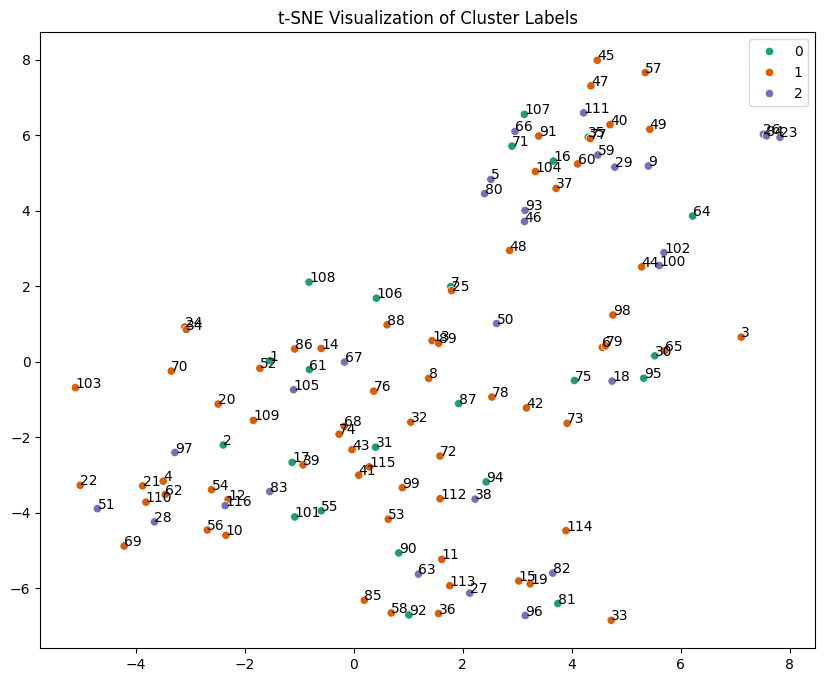

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=402)
tsne_results = tsne.fit_transform(all_stats_array)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=z, palette='Dark2')
plt.title('t-SNE Visualization of Cluster Labels')
for i in range(0,116):
    plt.annotate(i+1, (tsne_results[i, 0], tsne_results[i, 1]))
plt.show()

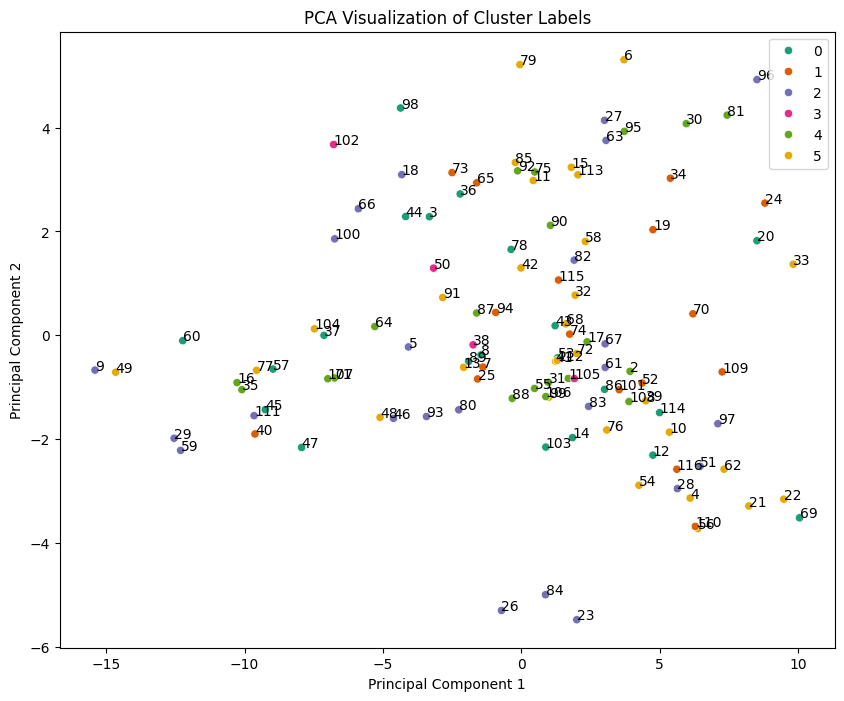

In [ ]:
# prompt: Do PCA on the all_stats_array and make a scatterplot between PCA 1st and 2nd component

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming 'all_stats_array' is already defined from previous code

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_file_stats)

# Apply PCA
pca = PCA(n_components=5) # Reduce to 2 principal components
pca_result = pca.fit_transform(scaled_data)

z = [4, 4, 0, 5, 2, 5, 1, 0, 2, 5, 5, 0, 5, 0, 5, 4, 4, 2, 1, 0, 5, 5, 2, 1, 1, 2, 2, 2, 2, 4, 4, 5, 5, 1, 4, 0, 0, 3, 5, 1, 5, 5, 0, 0, 0, 2, 0, 5, 5, 3, 2, 1, 0, 5, 4, 5, 0, 5, 2, 0, 2, 5, 2, 4, 1, 2, 2, 5, 0, 1, 4, 5, 1, 1, 4, 5, 5, 0, 5, 2, 4, 2, 2, 2, 5, 0, 4, 4, 0, 4, 5, 4, 2, 1, 4, 2, 2, 0, 5, 2, 1, 3, 0, 5, 3, 4, 4, 4, 1, 1, 2, 5, 5, 0, 1, 1]

# Create a scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=z, palette='Dark2')
plt.title('PCA Visualization of Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i in range(0,116):
    plt.annotate(i+1, (pca_result[i, 0], pca_result[i, 1]))
plt.show()